In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
from collections import Counter
from joblib import Parallel, delayed
from multiprocessing import cpu_count

ModuleNotFoundError: No module named 'joblib'

In [ ]:
labels = open(os.path.join('data','labels.txt'), 'r').read().splitlines()

In [43]:
from sklearn.metrics import classification_report

paths = [rp for rp in glob.glob('*/results.csv')]
reports = dict()
for result_path in paths:
    model_name = os.path.split(result_path)[0]
    results = pd.read_csv(result_path)
    target_names = results.y_true.unique()
    print('\n' + model_name)
    report = classification_report(results.y_true, results.y_pred, target_names=target_names, output_dict=True)
    reports[model_name] = pd.DataFrame(report).transpose()
    print(reports[model_name].head())


char_cnn
               f1-score  precision    recall  support
Very-Low       0.723140   0.688976  0.760870    690.0
Low            0.816783   0.789189  0.846377    690.0
Moderate-Low   0.645110   0.707612  0.592754    690.0
Moderate-High  0.711297   0.684564  0.740203    689.0
High           0.729814   0.783333  0.683140    344.0

lstm
               f1-score  precision    recall  support
Very-Low       0.630607   0.578692  0.692754    690.0
Low            0.778417   0.772857  0.784058    690.0
Moderate-Low   0.525220   0.586762  0.475362    690.0
Moderate-High  0.634831   0.614966  0.656023    689.0
High           0.607784   0.626543  0.590116    344.0

bilstm
               f1-score  precision    recall  support
Very-Low       0.629261   0.616992  0.642029    690.0
Low            0.767560   0.767004  0.768116    690.0
Moderate-Low   0.570122   0.601286  0.542029    690.0
Moderate-High  0.646325   0.618858  0.676343    689.0
High           0.640602   0.663551  0.619186    344.0


### Test Evaluation

#### Precision-Recall (PR) Curve

In [3]:
from pdb import set_trace as bp

def calc_pr(results, neg_labels, min_thresh, max_thresh, step, include_thresholds=False, only_recall=False):
    pos_labels = set(results.y_true.tolist()) - set(neg_labels)
    results = results.sort_values('y_conf', ascending=False)
    thresholds = np.arange(min_thresh, max_thresh, step)[::-1]
    
    bucket_index = 0
    bucket_cutoffs = []
    for i, yc in enumerate(results.y_conf):
        if yc >= thresholds[bucket_index]:
            continue
        else:
            bucket_cutoffs.append(i)
            bucket_index += 1
            if bucket_index >= len(thresholds):
                break

    if bucket_index < len(thresholds) and yc >= thresholds[bucket_index]:
        bucket_cutoffs.append(i)

    threshold_cutoffs = list(zip(thresholds, bucket_cutoffs))
    
    tp, fp, fn = Counter(), Counter(), Counter()

    prev_cutoff = 0
    micro_recall = []
    micro_precision = []
    relevant_samples = len(results)

    for thresh, cutoff in threshold_cutoffs:
        bucket = results.iloc[prev_cutoff:cutoff]
        for row in bucket.itertuples():
            y_pred = row.y_pred
            y_true = row.y_true

            if y_pred in pos_labels and y_true in pos_labels:
                if y_pred == y_true:
                    tp[y_pred] += 1
                else:
                    fp[y_pred] += 1
            elif y_pred in pos_labels and y_true not in pos_labels:
                fp[y_pred] += 1
            elif y_pred not in pos_labels and y_true in pos_labels:
                fn[y_true] += 1
            else: # y_true not in pos_labels and y_pred not in pos_labels
                pass

        tp_sum = sum(tp.values())
        fp_sum = sum(fp.values())

        micro_recall.append(tp_sum/max(relevant_samples, 1))
        micro_precision.append(tp_sum/max((tp_sum + fp_sum), 1))
        prev_cutoff = cutoff
    
    if only_recall:
        return micro_recall
    if include_thresholds:
        return (micro_precision, micro_recall), thresholds
    else:
        return (micro_precision, micro_recall)

#### Precision-Recall Curve

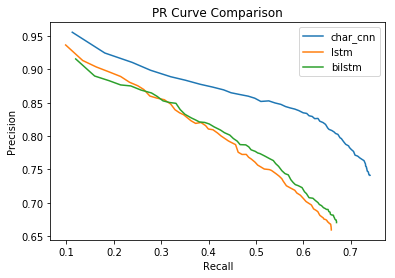

In [30]:
from joblib import Parallel, delayed
from multiprocessing import cpu_count

def get_pr(result_path):
    model_name = os.path.split(result_path)[0]
    results = pd.read_csv(result_path)
    (micro_p, micro_r) = calc_pr(results, {}, 0, 1, 0.01)
    return model_name, micro_p, micro_r

paths = [rp for rp in glob.glob('*/results.csv')]
results = Parallel(n_jobs=cpu_count(), require='sharedmem')(delayed(get_pr)(rp) for rp in paths)
for model_name, micro_p, micro_r in results:
    plt.plot(micro_r, micro_p, label=model_name)

plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve Comparison')
plt.show()

#### Recall-Threshold Curve

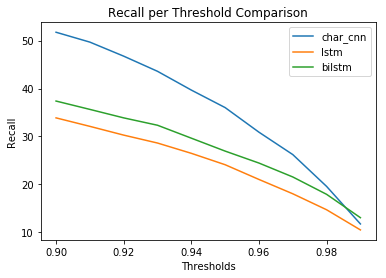

In [37]:
def plot_recall_curve(name, df, prediction_label, confidence_label,
                   thresh_min=0.9, thresh_max=1, thresh_step = 0.01):
    thresh = np.arange(thresh_min,thresh_max, thresh_step)

    sample = df[[prediction_label, confidence_label]]
    recall = [sum(sample[confidence_label] >= t)/len(sample) for t in thresh]

    plt.plot(thresh, np.asarray(recall)*100, label=name)
    plt.xlabel('Thresholds')
    plt.ylabel('Recall')
    plt.legend()
    
prediction_label = 'y_pred'
confidence_label = 'y_conf'

paths = [rp for rp in glob.glob('*/results.csv')]
for result_path in paths:
    model_name = os.path.split(result_path)[0]
    results = pd.read_csv(result_path)
    plot_recall_curve(model_name, results, prediction_label, confidence_label)
    plt.title('Recall per Threshold Comparison')